# Experiment 5 - Maximum Balancing with 64x64 Resizing

This experiment consists on the pre-processing data pipeline established below:

- Data Balancing with Reduction + Oversampling, resulting in 2,100 training images as final dataset.
- Image Resizing to 64x64 in order to improve performance.
- Pixel Values Normalisation to range 0 to 1.

No further data augmentation was implemented during this experiment

## Initial Setup

This initial setup is used to allow direct import of classes from other Notebooks available on Google Colab.

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

## Libraries Import

In [11]:
from google.colab import drive
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7, EfficientNetV2M, ResNet50V2, ResNet152V2, InceptionV3, DenseNet121, DenseNet201
import tensorflow as tf
from isic2018_task3_data_preprocessing import DataBalancer, DataPreparer, ModelSpecificProcessor
from isic2018_task3_models import BaseModel
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Instances of the class

In [12]:
db = DataBalancer()
dp = DataPreparer()
msp = ModelSpecificProcessor()

## Train Data Pre-Processing

### Capture and prepare labels data

In this step, the csv file containing diagnosis of lesion type is captured into a dataframe and transformed to provide labels in a single lesion type feature, encode categorical labels, and store image full path based on Google Drive folder structure.

In [13]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df = dp.labelPathMapper(df, 'train')
df.head()

,image,lesion_type,label_encoded,img_path
0,ISIC_0024306,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,MEL,1,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [15]:
# Check for any issues with img_path
missing_files = [f for f in df['img_path'].values if not os.path.exists(f)]
print(f"Missing files: {len(missing_files)}")
if missing_files:
    print("Example missing path:", missing_files[0])

Missing files: 0


### Data Balancing

For this experiment, the data balance consists of identifying the lesion type with highest record count (based on ISIC 2018 Train Dataset, this corresponds to lesion type NV with 6,705 records), and oversampling all other classes to match the same record count.<br><br>
There are 7 categories, which when oversampled to 6,705 per category provides 46,935 records.

In [16]:
df, ds_train = db.maxBalancing(df)

<Axes: xlabel='label_encoded', ylabel='count'>

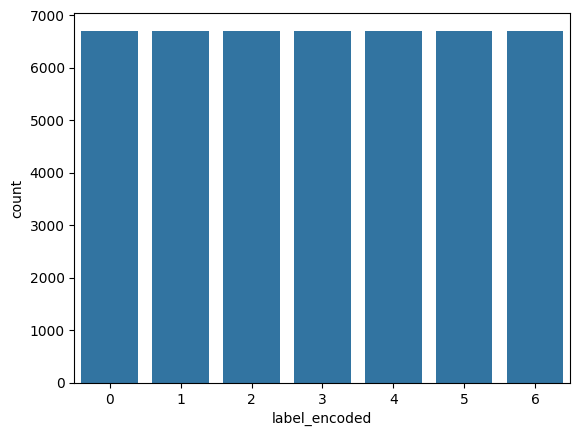

In [17]:
# Check df balance after balancing step
sns.countplot(x='label_encoded', data=df)

### Image Resizing and Normalisation

In [18]:
HEIGHT = 64
WIDTH = 64

def resize_wrapper(path, label):
    return dp.imageResizer(path, label, HEIGHT, WIDTH)

ds_train = ds_train.map(resize_wrapper)

In [19]:
ds_train = ds_train.map(dp.pixelNormalizer)

In [20]:
# Shuffle dataset to provide higher diversity per batch
ds_train = ds_train.shuffle(buffer_size=len(df))

In [21]:
BATCH_SIZE = 32

# Update shape to match model Sequential.call() shape
ds_train = ds_train.batch(BATCH_SIZE)

## Validation and Test Data Pre-Processing

In [22]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
df_validate = dp.labelPathMapper(df_validate, 'validate')

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
df_test = dp.labelPathMapper(df_test, 'test')

In [23]:
# Build image tensorflow dataset

ds_validate = db.buildDS(df_validate)
ds_test = db.buildDS(df_test)

In [24]:
# Image resizing

ds_validate = ds_validate.map(resize_wrapper)
ds_test = ds_test.map(resize_wrapper)

In [25]:
# Pixel values normalisation

ds_validate = ds_validate.map(dp.pixelNormalizer)
ds_test = ds_test.map(dp.pixelNormalizer)

In [26]:
# Update shape to match model Sequential.call() shape

ds_validate = ds_validate.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

## Model Building, Training and Validating

In [27]:
NUM_CLASSES = len(df.lesion_type.unique())
CHANNELS = 3
EPOCHS = 8

In [28]:
# Instance of Models class
bm = BaseModel(NUM_CLASSES, HEIGHT, WIDTH, CHANNELS)

In [29]:
# Function to support epoch plotting

def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [30]:
# Function to support confusion matrix plotting
def conf_matrix(ds, model):
  y_true = []
  y_pred = []

  for images, labels in ds:
      preds = model.predict(images)
      y_true.extend(labels.numpy())
      y_pred.extend(np.argmax(preds, axis=1))
  cm = confusion_matrix(y_true, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  return disp

In [31]:
# Build Base Models

# Custom CNN Model
custom_CNN = bm.customCNN()
# EfficientNet Models
base_modelENB0 = bm.modelENB0()
base_modelENB4 = bm.modelENB4()
base_modelENB7 = bm.modelENB7()
base_modelENV2M = bm.modelENV2M()
# ResNet Models
base_modelRN50V2 = bm.modelRN50V2()
base_modelRN152V2 = bm.modelRN152V2()
# DenseNet Models
base_modelDN121 = bm.modelDN121()
base_modelDN201 = bm.modelDN201()

# Build custom Fully Connected Layer
custom_final_layer = bm.finalLayer()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Custom CNN

In [24]:
modelCNN = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    custom_CNN,
])

modelCNN.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelCNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 7)              │       692,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,807 (2.64 MB)

 Trainable params: 692,359 (2.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
start_time = time.time()
histCNN = modelCNN.fit(ds_train, epochs=EPOCHS, validation_data=ds_validate)
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 1614s 351ms/step - accuracy: 0.5332 - loss: 1.2981 - val_accuracy: 0.4870 - val_loss: 2.3003
Epoch 2/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 830s 307ms/step - accuracy: 0.8261 - loss: 0.4692 - val_accuracy: 0.5492 - val_loss: 3.1801
Epoch 3/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 892s 334ms/step - accuracy: 0.8959 - loss: 0.2769 - val_accuracy: 0.4819 - val_loss: 3.2477
Epoch 4/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 874s 326ms/step - accuracy: 0.9212 - loss: 0.2128 - val_accuracy: 0.6062 - val_loss: 3.3807
Epoch 5/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 837s 310ms/step - accuracy: 0.9445 - loss: 0.1514 - val_accuracy: 0.6269 - val_loss: 3.6413
Epoch 6/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 823s 304ms/step - accuracy: 0.9547 - loss: 0.1298 - val_accuracy: 0.6580 - val_loss: 3.0893
Epoch 7/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 869s 316ms/step - accuracy: 0.9654 - loss: 0.1006 - val_accuracy: 0.6373 - val_loss: 4.7012
Epoch 8/8
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 824s 285ms/step - accuracy:

In [26]:
loss, accuracy = modelCNN.evaluate(ds_validate)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.6110 - loss: 7.4047
Overall accuracy on validation set: 64.25%


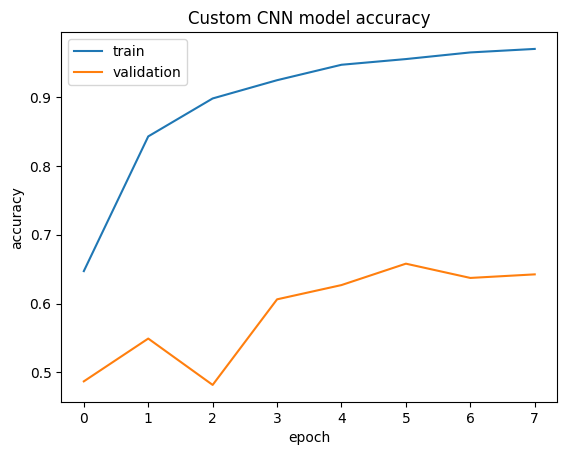

In [29]:
plot_hist(histCNN, "Custom CNN")

In [27]:
predsCNN = modelCNN.predict(ds_validate.take(1))
print(predsCNN.argmax(axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
[0 0 5 0 0 0 0 0 0 0 0 5 3 0 0 1 5 0 5 0 0 2 5 5 5 0 0 0 0 0 0 5]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


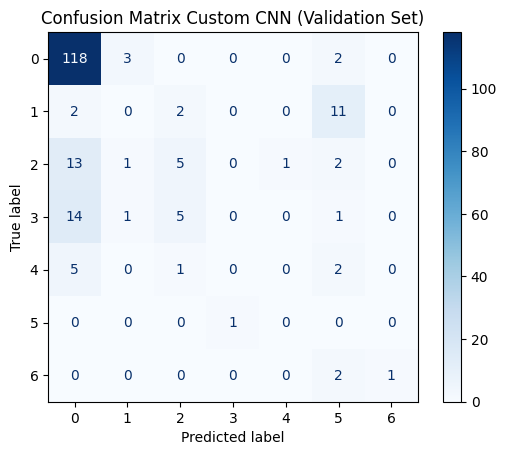

In [28]:
disp = conf_matrix(ds_validate, modelCNN)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix Custom CNN (Validation Set)')
plt.show()

In [30]:
model_save_name = 'modelCNN-Experiment5.keras'
pathCNNModel = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/{model_save_name}"
modelCNN.save(pathCNNModel)

### EfficientNet Models

EfficientNet is a family of Convolutional Neural Networks (CNNs) that scales up models using compound coefficient, which uniformally scales each dimension with fixed coefficients, simultaneously increasing width, depth, and resolution.

In [ ]:
ds_train_EN = ds_train.map(msp.efficientNetPrep)
ds_validate_EN = ds_validate.map(msp.efficientNetPrep)
ds_test_EN = ds_test.map(msp.efficientNetPrep)

#### EfficientNet-B0

In [ ]:
modelENB0 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    base_modelENB0,
    layers.Flatten(),
    custom_final_layer,
])

modelENB0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB0.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 7)              │       664,199 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,713,770 (17.98 MB)

 Trainable params: 4,671,747 (17.82 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [1]:
start_time = time.time()
histENB0 = modelENB0.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B0 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [2]:
loss, accuracy = modelENB0.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [3]:
plot_hist(histENB0, "EfficientNet-B0")

In [4]:
disp = conf_matrix(ds_validate_EN, modelENB0)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B0 (Validation Set)')
plt.show()

#### EfficientNet-B4

In [ ]:
modelENB4 = models.Sequential([
    base_modelENB4,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENB4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 2, 2, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,600,166 (70.95 MB)

 Trainable params: 18,474,959 (70.48 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [5]:
start_time = time.time()
histENB4 = modelENB4.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B4 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [6]:
loss, accuracy = modelENB4.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [7]:
plot_hist(histENB4, "EfficientNet-B4")

In [8]:
disp = conf_matrix(ds_validate_EN, modelENB4)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B4 (Validation Set)')
plt.show()

#### EfficientNet-B7

In [ ]:
modelENB7 = models.Sequential([
    base_modelENB7,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENB7.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENB7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2, 2, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,417,246 (249.55 MB)

 Trainable params: 65,106,519 (248.36 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [32]:
start_time = time.time()
histENB7 = modelENB7.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B7 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [33]:
loss, accuracy = modelENB7.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [34]:
plot_hist(histENB7, "EfficientNet-B7")

In [35]:
disp = conf_matrix(ds_validate_EN, modelENB7)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B7 (Validation Set)')
plt.show()

#### EfficientNetV2-M

In [ ]:
modelENV2M = models.Sequential([
    base_modelENV2M,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENV2M.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelENV2M.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)   │ (None, 2, 2, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,814,587 (205.29 MB)

 Trainable params: 53,522,555 (204.17 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [36]:
start_time = time.time()
histENV2M = modelENV2M.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNetV2-M Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [37]:
loss, accuracy = modelENV2M.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [38]:
plot_hist(histENV2M, "EfficientNetV2-M")

In [39]:
disp = conf_matrix(ds_validate_EN, modelENV2M)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNetV2-M (Validation Set)')
plt.show()

### ResNet Models

In [ ]:
ds_train_RN = ds_train.map(msp.resNetPrep)
ds_validate_RN = ds_validate.map(msp.resNetPrep)
ds_test_RN = ds_test.map(msp.resNetPrep)

#### ResNet50V2

In [ ]:
modelRN50V2 = models.Sequential([
    base_modelRN50V2,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelRN50V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelRN50V2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,622,215 (93.93 MB)

 Trainable params: 24,576,775 (93.75 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [40]:
start_time = time.time()
histRN50V2 = modelRN50V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet50V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [41]:
loss, accuracy = modelRN50V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [42]:
plot_hist(histRN50V2, "ResNet50V2")

In [43]:
disp = conf_matrix(ds_validate_RN, modelRN50V2)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix ResNet50V2 (Validation Set)')
plt.show()

#### ResNet152V2

In [ ]:
modelRN152V2 = models.Sequential([
    base_modelRN152V2,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelRN152V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelRN152V2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 2, 2, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,389,063 (226.55 MB)

 Trainable params: 59,245,319 (226.00 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [44]:
start_time = time.time()
histRN152V2 = modelRN152V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet152V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [45]:
loss, accuracy = modelRN152V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [46]:
plot_hist(histRN152V2, "ResNet152V2")

In [47]:
disp = conf_matrix(ds_validate_RN, modelRN152V2)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix ResNet152V2 (Validation Set)')
plt.show()

### Inception Models

#### InceptionV3

InceptionV3 requires images sizes of minimum 75x75, therefore this model was not applied to the dataset in this experiment.

### DenseNet Models

In [ ]:
ds_train_DN = ds_train.map(msp.denseNetPrep)
ds_validate_DN = ds_validate.map(msp.denseNetPrep)
ds_test_DN = ds_test.map(msp.denseNetPrep)

#### DenseNet121

In [ ]:
modelDN121 = models.Sequential([
    base_modelDN121,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelDN121.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelDN121.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,570,631 (28.88 MB)

 Trainable params: 7,486,983 (28.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [48]:
start_time = time.time()
histDN121 = modelDN121.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet121 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [50]:
loss, accuracy = modelDN121.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [49]:
plot_hist(histDN121, "DenseNet121")

In [51]:
disp = conf_matrix(ds_validate_DN, modelDN121)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix DenseNet121 (Validation Set)')
plt.show()

#### DenseNet201

In [ ]:
modelDN201 = models.Sequential([
    base_modelDN201,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelDN201.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelDN201.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 2, 2, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,313,863 (73.68 MB)

 Trainable params: 19,084,807 (72.80 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [52]:
start_time = time.time()
histDN201 = modelDN201.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet201 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [53]:
loss, accuracy = modelDN201.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

In [54]:
plot_hist(histDN201, "DenseNet201")

In [55]:
disp = conf_matrix(ds_validate_DN, modelDN201)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix DenseNet201 (Validation Set)')
plt.show()